In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError


PATH_TO_DATA = 'ecg.csv'
dataframe = pd.read_csv(PATH_TO_DATA, header=None)
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
dataframe.shape

(4998, 141)

In [3]:
# last column is the Label
# 0 = anomaly, 1 = normal
LAST = 140

data = dataframe.drop(LAST, axis=1)
labels = dataframe[LAST]

In [4]:
print(data)

           0         1         2         3         4         5         6    \
0    -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1    -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2    -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3     0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4     0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   
...        ...       ...       ...       ...       ...       ...       ...   
4993  0.608558 -0.335651 -0.990948 -1.784153 -2.626145 -2.957065 -2.931897   
4994 -2.060402 -2.860116 -3.405074 -3.748719 -3.513561 -3.006545 -2.234850   
4995 -1.122969 -2.252925 -2.867628 -3.358605 -3.167849 -2.638360 -1.664162   
4996 -0.547705 -1.889545 -2.839779 -3.457912 -3.929149 -3.966026 -3.492560   
4997 -1.351779 -2.209006 -2.520225 -3.061475 -3.065141 -3.030739 -2.622720   

           7         8         9    ...       130       131    

In [5]:
print(labels)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4993    0.0
4994    0.0
4995    0.0
4996    0.0
4997    0.0
Name: 140, Length: 4998, dtype: float64


In [6]:
print(labels)

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
4993    0.0
4994    0.0
4995    0.0
4996    0.0
4997    0.0
Name: 140, Length: 4998, dtype: float64


In [7]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [8]:
# use case is novelty detection so use only the normal data for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

In [9]:
# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [10]:
class AutoEncoder(Model):
  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [11]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])

model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 3s 160ms/step - loss: 0.0113 - mse: 0.0256 - val_loss: 0.0131 - val_mse: 0.0301
Epoch 2/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0109 - mse: 0.0245 - val_loss: 0.0127 - val_mse: 0.0292
Epoch 3/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0100 - mse: 0.0227 - val_loss: 0.0120 - val_mse: 0.0276
Epoch 4/20
5/5 [==============================] - 0s 26ms/step - loss: 0.0089 - mse: 0.0200 - val_loss: 0.0116 - val_mse: 0.0265
Epoch 5/20
5/5 [==============================] - 0s 40ms/step - loss: 0.0078 - mse: 0.0175 - val_loss: 0.0110 - val_mse: 0.0253
Epoch 6/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0068 - mse: 0.0153 - val_loss: 0.0107 - val_mse: 0.0244
Epoch 7/20
5/5 [==============================] - 0s 28ms/step - loss: 0.0061 - mse: 0.0136 - val_loss: 0.0103 - val_mse: 0.0235
Epoch 8/20
5/5 [==============================] - 0s 30ms/step - loss: 0.0056 - mse: 0.0125 - va

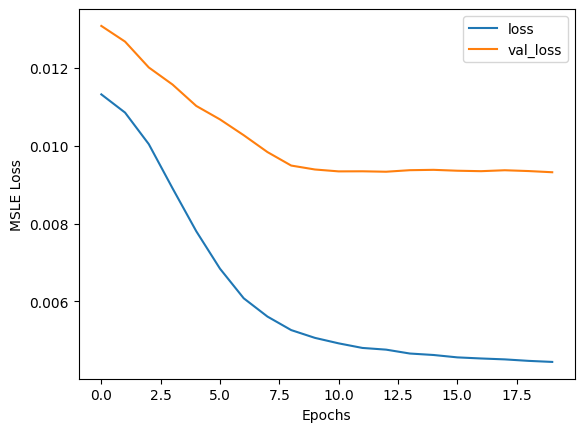

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [13]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 0 = anomaly, 1 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

73/73 [==============================] - 0s 3ms/step
Threshold: 0.009672825584110766


In [14]:
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

32/32 [==============================] - 0s 3ms/step


0.95